# Section: Securing Federated Learning

- Lesson 1: Trusted Aggregator
- Lesson 2: Intro to Additive Secret Sharing
- Lesson 3: Intro to Fixed Precision Encoding
- Lesson 4: Secret Sharing + Fixed Precision in PySyft
- Final Project: Federated Learning wtih Encrypted Gradient Aggregation

# Lesson: Federated Learning with a Trusted Aggregator

In the last section, we learned how to train a model on a distributed dataset using Federated Learning. In particular, the last project aggregated gradients directly from one data owner to another. 

However, while in some cases it could be ideal to do this, what would be even better is to be able to choose a neutral third party to perform the aggregation.

As it turns out, we can use the same tools we used previously to accomplish this.

# Project: Federated Learning with a Trusted Aggregator

In [1]:
import numpy as np
import torch as th
from torchvision import datasets,transforms
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import syft as sy
hook = sy.TorchHook(th)

In [2]:
bob = sy.VirtualWorker(hook,id="bob")
alice = sy.VirtualWorker(hook,id="alice")
secure_worker = sy.VirtualWorker(hook,id="secure_worker")

In [3]:
bob.add_workers([alice,secure_worker])
alice.add_workers([bob,secure_worker])
secure_worker.add_workers([alice,bob])

<VirtualWorker id:secure_worker #objects:0>

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the train and test data by using the transform
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [5]:
num_workers = 2
batch_size = 32
teacher_loaders = []
data_size = len(train_data)//num_workers
print(data_size)
alices_indices = list(range(0,data_size))
bobs_indices = list(range(data_size+1, data_size*num_workers))
alices_data = Subset(train_data,alices_indices)
alices_loader = th.utils.data.DataLoader(alices_data, batch_size = batch_size,shuffle=True)
bobs_data = Subset(train_data,bobs_indices)
bobs_loader = th.utils.data.DataLoader(bobs_data, batch_size = batch_size,shuffle=True)

30000


In [32]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,64)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer with softmax activation
        x = F.log_softmax(self.output(x),dim=1)
        
        return x
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


In [41]:
num_rounds = 20
n_steps = 1
bobs_criterion = nn.NLLLoss().send(bob)
alices_criterion = nn.NLLLoss().send(alice)

for round_iter in range(num_rounds):
    print("Epoch: " + str(round_iter))
    bobs_model = model.copy().send(bob)
    alices_model = model.copy().send(alice)
    
    bobs_opt = optim.SGD(params= bobs_model.parameters(), lr = 0.1)
    alices_opt = optim.SGD(params = alices_model.parameters(),lr = 0.1)
    b_running_loss = 0
    a_running_loss = 0
    for i in range(n_steps):
        #print("Step Number: " + str(i))
        for images,labels in bobs_loader:
            bobs_opt.zero_grad()
            images = images.view(images.shape[0], -1)
            bobs_pred = bobs_model(images.send(bob))
            bobs_loss = bobs_criterion(bobs_pred,labels.send(bob))
            bobs_loss.backward()
        
            bobs_opt.step()
            bobs_loss= bobs_loss.get().data
            b_running_loss += bobs_loss
        else:
            print(f" Bobs Training loss: {b_running_loss/len(bobs_loader)}")
        for images, labels in alices_loader:
            alices_opt.zero_grad()
            images = images.view(images.shape[0], -1)
            alices_pred = alices_model(images.send(alice))
            alices_loss = alices_criterion(alices_pred,labels.send(alice))
            alices_loss.backward()
        
            alices_opt.step()
            alices_loss= alices_loss.get().data
            a_running_loss += alices_loss
        else:
            print(f" Alices Training loss: {a_running_loss/len(alices_loader)}")
    
    alices_model.move(secure_worker)
    bobs_model.move(secure_worker)
    with th.no_grad():
        model.fc1.weight.set_(((alices_model.fc1.weight.data + bobs_model.fc1.weight.data)/2).get())
        model.fc1.bias.set_(((alices_model.fc1.bias.data + bobs_model.fc1.bias.data)/2).get())
        model.fc2.weight.set_(((alices_model.fc2.weight.data + bobs_model.fc2.weight.data)/2).get())
        model.fc2.bias.set_(((alices_model.fc2.bias.data + bobs_model.fc2.bias.data)/2).get())
        model.output.weight.set_(((alices_model.output.weight.data + bobs_model.output.weight.data)/2).get())
        model.output.bias.set_(((alices_model.output.bias.data + bobs_model.output.bias.data)/2).get())
    secure_worker.clear_objects()
    
    #print("Bob: " + str(bobs_loss) + " Alice: " + str(alices_loss))

Epoch: 0
 Bobs Training loss: 0.08879061788320541
 Alices Training loss: 0.08507691323757172
Bob: tensor(0.0362) Alice: tensor(0.0030)
Epoch: 1
 Bobs Training loss: 0.08348900824785233
 Alices Training loss: 0.07703496515750885
Bob: tensor(0.0029) Alice: tensor(0.1927)
Epoch: 2
 Bobs Training loss: 0.07518904656171799
 Alices Training loss: 0.07076212763786316
Bob: tensor(0.0219) Alice: tensor(0.0722)
Epoch: 3
 Bobs Training loss: 0.07063933461904526
 Alices Training loss: 0.06404294073581696
Bob: tensor(0.0019) Alice: tensor(0.0197)
Epoch: 4
 Bobs Training loss: 0.06535372138023376
 Alices Training loss: 0.06045011803507805
Bob: tensor(0.0512) Alice: tensor(0.0229)
Epoch: 5
 Bobs Training loss: 0.061566200107336044
 Alices Training loss: 0.05657114461064339
Bob: tensor(0.0554) Alice: tensor(0.1458)
Epoch: 6
 Bobs Training loss: 0.057879604399204254
 Alices Training loss: 0.053091488778591156
Bob: tensor(0.0640) Alice: tensor(0.3682)
Epoch: 7
 Bobs Training loss: 0.051454994827508926
 

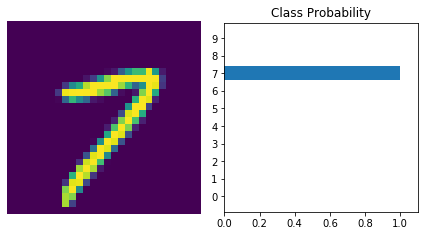

In [57]:
%matplotlib inline
import helper
images, labels = next(iter(alices_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with th.no_grad():
    logps =model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities

ps = th.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

# Lesson: Intro to Additive Secret Sharing

While being able to have a trusted third party to perform the aggregation is certainly nice, in an ideal setting we wouldn't have to trust anyone at all. This is where Cryptography can provide an interesting alterantive. 

Specifically, we're going to be looking at a simple protocol for Secure Multi-Party Computation called Additive Secret Sharing. This protocol will allow multiple parties (of size 3 or more) to aggregate their gradients without the use of a trusted 3rd party to perform the aggregation. In other words, we can add 3 numbers together from 3 different people without anyone ever learning the inputs of any other actors.

Let's start by considering the number 5, which we'll put into a varible x

In [13]:
x = 5

Let's say we wanted to SHARE the ownership of this number between two people, Alice and Bob. We could split this number into two shares, 2, and 3, and give one to Alice and one to Bob

In [14]:
bob_x_share = 2
alice_x_share = 3

decrypted_x = bob_x_share + alice_x_share
decrypted_x

5

Note that neither Bob nor Alice know the value of x. They only know the value of their own SHARE of x. Thus, the true value of X is hidden (i.e., encrypted). 

The truly amazing thing, however, is that Alice and Bob can still compute using this value! They can perform arithmetic over the hidden value! Let's say Bob and Alice wanted to multiply this value by 2! If each of them multiplied their respective share by 2, then the hidden number between them is also multiplied! Check it out!

In [15]:
bob_x_share = 2 * 2
alice_x_share = 3 * 2

decrypted_x = bob_x_share + alice_x_share
decrypted_x

10

This even works for addition between two shared values!!

In [16]:
# encrypted "5"
bob_x_share = 2
alice_x_share = 3

# encrypted "7"
bob_y_share = 5
alice_y_share = 2

# encrypted 5 + 7
bob_z_share = bob_x_share + bob_y_share
alice_z_share = alice_x_share + alice_y_share

decrypted_z = bob_z_share + alice_z_share
decrypted_z

12

As you can see, we just added two numbers together while they were still encrypted!!!

One small tweak - notice that since all our numbers are positive, it's possible for each share to reveal a little bit of information about the hidden value, namely, it's always greater than the share. Thus, if Bob has a share "3" then he knows that the encrypted value is at least 3.

This would be quite bad, but can be solved through a simple fix. Decryption happens by summing all the shares together MODULUS some constant. I.e.

In [17]:
x = 5

Q = 23740629843760239486723

bob_x_share = 23552870267 # <- a random number
alice_x_share = Q - bob_x_share + x
alice_x_share

23740629843736686616461

In [18]:
(bob_x_share + alice_x_share) % Q

5

So now, as you can see, both shares are wildly larger than the number being shared, meaning that individual shares no longer leak this inforation. However, all the properties we discussed earlier still hold! (addition, encryption, decryption, etc.)

# Project: Build Methods for Encrypt, Decrypt, and Add 

In this project, you must take the lessons we learned in the last section and write general methods for encrypt, decrypt, and add. Store shares for a variable in a tuple like so.

In [19]:
x_share = (2,5,7)

Even though normally those shares would be distributed amongst several workers, you can store them in ordered tuples like this for now :)

In [ ]:
def encrypt(number, n_shares):
    #para numero de shares
        # se n< number
            #dividir por um aletaorio (que de resto)
                #entrada i recebe o aleatorio                
        # senao
            #ultimar share = resto
    return shares
def decrypt(tuple_shares):
    
    
    return decrypt_value
    
    

# Lesson: Intro to Fixed Precision Encoding

As you may remember, our goal is to aggregate gradients using this new Secret Sharing technique. However, the protocol we've just explored in the last section uses positive integers. However, our neural network weights are NOT integers. Instead, our weights are decimals (floating point numbers).

Not a huge deal! We just need to use a fixed precision encoding, which lets us do computation over decimal numbers using integers!

In [25]:
BASE=10
PRECISION=4

In [26]:
def encode(x):
    return int((x * (BASE ** PRECISION)) % Q)

def decode(x):
    return (x if x <= Q/2 else x - Q) / BASE**PRECISION

In [27]:
encode(3.5)

35000

In [28]:
decode(35000)

3.5

In [29]:
x = encrypt(encode(5.5))
y = encrypt(encode(2.3))
z = add(x,y)
decode(decrypt(z))

7.8

# Lesson: Secret Sharing + Fixed Precision in PySyft

While writing things from scratch is certainly educational, PySyft makes a great deal of this much easier for us through its abstractions.

In [30]:
bob = bob.clear_objects()
alice = alice.clear_objects()
secure_worker = secure_worker.clear_objects()

In [31]:
x = th.tensor([1,2,3,4,5])

### Secret Sharing Using PySyft

We can share using the simple .share() method!

In [32]:
x = x.share(bob, alice, secure_worker)

In [33]:
bob._objects

{35498656553: tensor([  10235770278698899, 1401398179551373756, 2277280072169145491,
          636965538565031298,  913795591610271305])}

and as you can see, Bob now has one of the shares of x! Furthermore, we can still call addition in this state, and PySyft will automatically perform the remote execution for us!

In [34]:
y = x + x

In [35]:
y

(Wrapper)>[AdditiveSharingTensor]
	-> (Wrapper)>[PointerTensor | me:23637986557 -> bob:30254176063]
	-> (Wrapper)>[PointerTensor | me:18229131498 -> alice:75856222543]
	-> (Wrapper)>[PointerTensor | me:34301722959 -> secure_worker:75419815101]
	*crypto provider: me*

In [36]:
y.get()

tensor([ 2,  4,  6,  8, 10])

### Fixed Precision using PySyft

We can also convert a tensor to fixed precision using .fix_precision()

In [37]:
x = th.tensor([0.1,0.2,0.3])

In [38]:
x

tensor([0.1000, 0.2000, 0.3000])

In [39]:
x = x.fix_prec()

In [40]:
x.child.child

tensor([100, 200, 300])

In [41]:
y = x + x

In [42]:
y = y.float_prec()
y

tensor([0.2000, 0.4000, 0.6000])

### Shared Fixed Precision

And of course, we can combine the two!

In [43]:
x = th.tensor([0.1, 0.2, 0.3])

In [44]:
x = x.fix_prec().share(bob, alice, secure_worker)

In [45]:
y = x + x

In [46]:
y.get().float_prec()

tensor([0.2000, 0.4000, 0.6000])

Make sure to make the point that people can see the model averages in the clear.

# Final Project: Federated Learning with Encrypted Gradient Aggregation